In [1]:
%pylab inline
import matplotlib as mpl
from pygadgetreader import *
from mpl_toolkits.mplot3d import Axes3D
import soda

/usr/lib/python3/dist-packages/matplotlib/__init__.py:760: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now '/home/ngaravito/.config'/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':16, 'family':'serif'}
matplotlib.rc('font', **font)

In [3]:
# First guess

In [7]:
host_model = ['hernquist', 1.57E12, 46, 15]
disk_params = [6.5E10, 3.5, 0.53]
bulge_params = [1E10, 0.7]
alpha = [0, 1]
d_t = 0.001
sat_model = ['hernquist', 1E11, 20]

In [8]:
t, sat_R, sat_V, host_R, host_V = soda.leapfrog.integrate(3, 'LMC', 'LMC', [0,0,0], [0,0,0], host_model, sat_model, 
                                                          disk_params, bulge_params, dfric=1,
                                                          alpha=alpha, dt=0.01, direction=1)

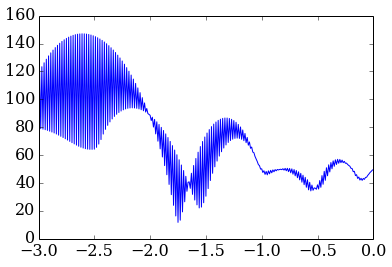

In [9]:
plot(t, np.sqrt(sat_R[:,0]**2 + sat_R[:,1]**2 + sat_R[:,2]**2))

In [1]:
# Function that reads the data from the Analytic integration
#Galactocentic distances and velocities
def reading_data(snap_name):
    host = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_host.txt')
    sat = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_sat.txt')
    t = host[:,0] 
    # Defining galactocentric distances and velocities
    x = sat[:,1] - host[:,1] 
    y = sat[:,2] - host[:,2] 
    z = sat[:,3] - host[:,3] 

    vx = sat[:,4] - host[:,4] 
    vy = sat[:,5] - host[:,5] 
    vz = sat[:,6] - host[:,6]        

    Rgal = np.sqrt(x**2.0 + y**2.0 + z**2.0)
    Vgal = np.sqrt(vx**2.0 + vy**2.0 + vz**2.0)
    
    return t, x, y, z, vx, vy, vz, Rgal, Vgal

# Host coordinates and velocities
def data_host(snap_name):
    host = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_host.txt')
    return host[:,1], host[:,2], host[:,3], host[:,4], host[:,5], host[:,6]

# Satellite coordinates and velocities
def data_sat(snap_name):
    sat = loadtxt('../../../orbits/data/lmc/'+ snap_name +'_sat.txt')
    return sat[:,1], sat[:,2], sat[:,3], sat[:,4], sat[:,5], sat[:,6]

#ICs
def ICs(Rgal, cut, x, y, z, vx, vy, vz, t):
    Rcut = np.where(Rgal>=cut)[0]
    return Rgal[Rcut[0]], x[Rcut[0]], y[Rcut[0]], z[Rcut[0]], vx[Rcut[0]], vy[Rcut[0]], vz[Rcut[0]], t[Rcut[0]]

#Function that reads the N-body sumulation orbit
def reading_Nbody(snap_name):
    data = np.loadtxt('orbits/' + snap_name)
    time = data[:,0]
    Rgal = data[:,1]
    x_sat= data[:,2]
    y_sat = data[:,3]
    z_sat = data[:,4]
    x_gal = data[:,5]
    y_gal = data[:,6]
    z_gal = data[:,7]
    Vgal = data[:,8]
    vx_sat = data[:,9]
    vy_sat = data[:,10]
    vz_sat = data[:,11]
    vx_gal = data[:,12]
    vy_gal = data[:,13]
    vz_gal = data[:,14]
    return time, Rgal, x_sat, y_sat, z_sat, x_gal, y_gal, z_gal, Vgal, vx_sat, vy_sat, vz_sat, vx_gal, vy_gal, vz_gal

def best_values(x, y, z, vx, vy, vz):
    x_obs = -1
    y_obs = -41
    z_obs = -28
    vx_obs = -57
    vy_obs = -226
    vz_obs = 221
    Robs = np.sqrt((x_obs-x)**2.0 + (y_obs-y)**2.0 + (z_obs-z)**2.0)
    index = np.where(Robs == min(Robs))[0]
    return x[index], y[index], z[index], vx[index], vy[index], vz[index]

In [4]:
#

In [4]:
tgal1, xgal1, ygal1, zgal1, vxgal1, vygal1, vzgal1, Rgal1, Vgal1 = reading_data('lmc4_MWHern1')
tNB, RgalNB, xsatNB, ysatNB, zsatNB, xgalNB, ygalNB, zgalNB, vgalNB, vxsatNB, \
vysatNB, vzsatNB, vxgalNB, vygalNB, vzgalNB = reading_Nbody('LMC4_H0.txt')

In [5]:
ric1, xic1, yic1, zic1, vxic1, vyic1, vzic1, tic1 = ICs(Rgal1, 280, xgal1, ygal1, zgal1, vxgal1, vygal1, vzgal1, tgal1)

In [6]:
RgNB = np.sqrt((xgalNB-xsatNB)**2.0 + (ygalNB - ysatNB)**2.0 + (zgalNB-zsatNB)**2.0)

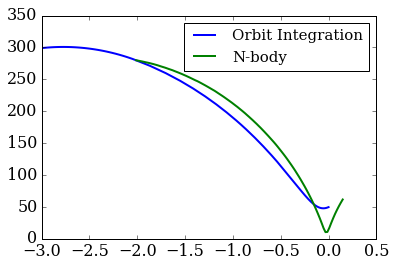

In [7]:
plot(tgal1, Rgal1, lw=2, label='Orbit Integration')
plot(tNB+tic1, RgNB, lw=2, label='N-body')
legend(fontsize=15)

In [8]:
print 'ICs for analytic iteration to match the Nbody orbit with differentd dfs:'
print 'x:', xsatNB[0]-xgalNB[0]
print 'y:', ysatNB[0]-ygalNB[0]
print 'z:', zsatNB[0]-zgalNB[0]

print 'vx:', vxsatNB[0]-vxgalNB[0]
print 'vy:', vysatNB[0]-vygalNB[0]
print 'vz:', vzsatNB[0]-vzgalNB[0]

ICs for analytic iteration to match the Nbody orbit with differentd dfs:
x: 20.338115
y: 266.912184
z: 82.080739
vx: 9.230692
vy: -31.772137
vz: 7.276471


In [9]:
print tNB[-1]

2.16


In [18]:
tgal05, xgal05, ygal05, zgal05, vxgal05, vygal05, vzgal05, Rgal05, Vgal05 = reading_data('lmc4_MWpmdf05')
tgal06, xgal06, ygal06, zgal06, vxgal06, vygal06, vzgal06, Rgal06, Vgal06 = reading_data('lmc4_MWpmdf06')
tgal07, xgal07, ygal07, zgal07, vxgal07, vygal07, vzgal07, Rgal07, Vgal07 = reading_data('lmc4_MWpmdf07')
tgal08, xgal08, ygal08, zgal08, vxgal08, vygal08, vzgal08, Rgal08, Vgal08 = reading_data('lmc4_MWpmdf08')
#tgal18, xgal18, ygal18, zgal18, vxgal18, vygal18, vzgal18, Rgal18, Vgal18 = reading_data('lmc6_MWpmdf18')
#tgal20, xgal20, ygal20, zgal20, vxgal20, vygal20, vzgal20, Rgal20, Vgal20 = reading_data('lmc6_MWpmdf20')


(0, 300)

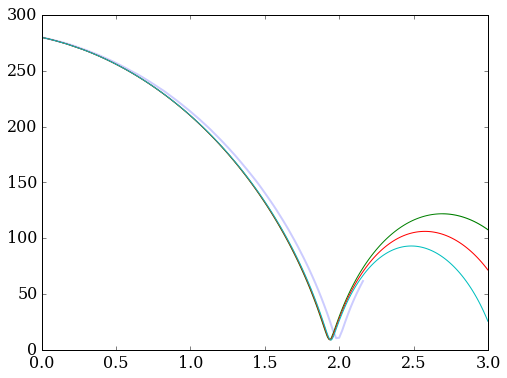

In [19]:
figure(figsize=(8, 6))
plot(tNB, RgNB, lw=2, alpha=0.2)
plot(tgal05, Rgal05)
plot(tgal06, Rgal06)
plot(tgal07, Rgal07)
#plot(tgal08, Rgal08)
#plot(tgal15, Rgal15)
#plot(tgal18, Rgal18)
#plot(tgal20, Rgal20)
#xlim(0.0, 1.4)
ylim(0, 300)

In [20]:
tgal045b, xgal045b, ygal045b, zgal045b, vxgal045b, vygal045b, vzgal045b, Rgal045b, Vgal045b = reading_data('lmc4_MWpmdf045b')
tgal05b, xgal05b, ygal05b, zgal05b, vxgal05b, vygal05b, vzgal05b, Rgal05b, Vgal05b = reading_data('lmc4_MWpmdf05b')
tgal055b, xgal055b, ygal055b, zgal055b, vxgal055b, vygal055b, vzgal055b, Rgal055b, Vgal055b = reading_data('lmc4_MWpmdf055b')
tgal06b, xgal06b, ygal06b, zgal06b, vxgal06b, vygal06b, vzgal06b, Rgal06b, Vgal06b = reading_data('lmc4_MWpmdf06b')

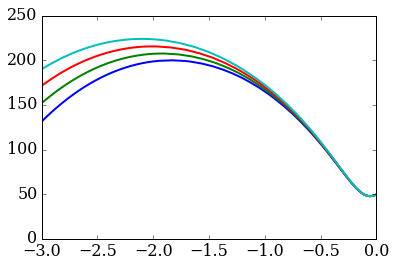

In [21]:
plot(tgal045b, Rgal045b, lw=2)
plot(tgal05b, Rgal05b, lw=2)
plot(tgal055b, Rgal055b, lw=2)
plot(tgal06b, Rgal06b, lw=2)

In [22]:
ric045, xic045, yic045, zic045, vxic045, vyic045, vzic045, tic045 = ICs(Rgal045b, 190,  xgal045b, ygal045b, zgal045b, vxgal045b, vygal045b, vzgal045b, tgal045b)
ric05, xic05, yic05, zic05, vxic05, vyic05, vzic05, tic05 = ICs(Rgal05b, 200,  xgal05b, ygal05b, zgal05b, vxgal05b, vygal05b, vzgal05b, tgal05b)
ric055, xic055, yic055, zic055, vxic055, vyic055, vzic055, tic055 = ICs(Rgal055b, 210,  xgal055b, ygal055b, zgal055b, vxgal055b, vygal055b, vzgal055b, tgal055b)
ric06, xic06, yic06, zic06, vxic06, vyic06, vzic06, tic06 = ICs(Rgal06b, 220,  xgal06b, ygal06b, zgal06b, vxgal06b, vygal06b, vzgal06b, tgal06b)


In [23]:
print "This are the ICs for the new Nbody: "
print xic045, yic045, zic045, vxic045, vyic045, vzic045
print xic05, yic05, zic05, vxic05, vyic05, vzic05
print xic055, yic055, zic055, vxic055, vyic055, vzic055
print xic06, yic06, zic06, vxic06, vyic06, vzic06

This are the ICs for the new Nbody: 
15.938147 184.318269 43.330524 10.949636 -22.197442 -99.102962
15.255384 191.783586 54.76852 11.616064 -11.796171 -94.946403
14.537944 198.811104 66.078902 12.088886 -2.755792 -90.558497
13.810617 205.552718 77.212577 12.40013 5.042759 -86.069407


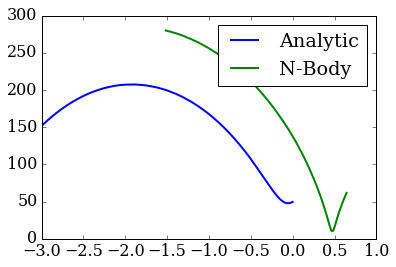

In [24]:
plot(tgal05b, Rgal05b, lw=2, label='Analytic')
plot(tNB+tic05, RgNB, lw=2, label='N-Body')
legend()

In [21]:
XNB =  xsatNB-xgalNB
YNB =  ysatNB-ygalNB
ZNB =  zsatNB-zgalNB
vxNB = vxsatNB - vxgalNB
vyNB = vysatNB - vygalNB
vzNB = vzsatNB - vzgalNB

In [23]:
best_values(XNB, YNB, ZNB, vxNB, vyNB, vzNB)

(array([-1.188773]),
 array([-44.966176]),
 array([-27.307176]),
 array([-66.796694]),
 array([-245.392623]),
 array([ 229.848162]))

In [28]:
snap_nuumber = np.where(YNB == -44.966176)[0]
print snap_nuumber

[119]
